# **Functional Arquitecture of V1**

The implementation of the fibrillar modelling of V1 presented in the final degree project **‘New vision models based on Neurogeometry’** is shown.

Joaquín Borrego Díaz and Domingo Paniagua Molina

## **Preloading some images and calculations**

Some test images are downloaded in order to check how the algorithm works. Calculations that we have saved by experimenting with the different images obtained with the model present in this notebook are also downloaded. The reason for loading this data is to be able to see how the algorithm works without having to wait for the computation of the algorithm, which is computationally expensive. It is also possible to test the algorithm on the basis of an image.

In [1]:
#!pip install gdown
!rm -rf img resultados safeCalcs sample_data
!mkdir -p img safeCalcs resultados
!gdown 1mCOAeLTl9LLQ0dulNGIZ0O9mpFA33-Dx -q -O ./img/images.zip
#descomprimo las imágenes
!unzip -q ./img/images.zip -d ./img #modo quiet
!rm -f ./img/images.zip

!gdown 1mXO0OTayqo8N11_S2URIqMvyjXujBv55 -q -O ./safeCalcs/calcs.zip
#descomprimo los cálculos guardados
!unzip -q ./safeCalcs/calcs.zip -d ./safeCalcs #modo quiet
!rm -f ./safeCalcs/calcs.zip

!echo "Cálculos e imágenes cargadas"

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
import plotly.graph_objects as go
import cv2
from tqdm.notebook import tqdm
import os
%matplotlib inline

Cálculos e imágenes cargadas


## **Gabor filters**

Let's visualize a gabor filter defined over $\mathbb{R}^2$: $$$$  $$\begin{aligned} \Psi : \mathbb{R}^2 &\longrightarrow \mathbb{C} \\ \Psi(x,y) &\longmapsto e^{-(x^2+y^2)} e^{2iy} \end{aligned}$$

In [11]:
def gabor(x,y,x0,y0,theta):
    return np.exp(-((x-x0)**2 + (y-y0)**2)) * np.exp(2j*(- np.sin(theta)*(x-x0) + np.cos(theta)*(y-y0)))

def plot_gabor(x0,y0,theta,plot3d=False):
    cmap = 'viridis'
    levels = 30

    #veamos un ejemplo
    x_gab = np.linspace(-4+x0,4+x0,1000)
    y_gab = np.linspace(-3+y0,3+y0,1000)

    X, Y = np.meshgrid(x_gab, y_gab)
    Z = gabor(X,Y,x0,y0,theta) #el ejemplo anterior

    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1,2,1)
    c1 = ax1.contourf(Y, X, Z.real, cmap=cmap,levels=levels)
    ax1.set_title("Real part of the filter with center ({},{}) and pref. orient. {:.3f}".format(x0,y0,theta))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylim(-2+y0,2+y0)
    plt.colorbar(c1,ax=ax1)

    ax2 = fig.add_subplot(1,2,2)
    c2 = ax2.contourf(Y, X, Z.imag, cmap=cmap,levels=levels)
    ax2.set_title('Imaginary part of the filter with center ({},{}) and pref. orient. {:.3f}'.format(x0,y0,theta))
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_ylim(-2+y0,2+y0)
    plt.colorbar(c2,ax=ax2)

    if plot3d:
        fig2 = plt.figure(figsize=(12,6))
        ax3 = fig2.add_subplot(1,1,1,projection='3d')
        ax3.plot_surface(Y,X,abs(Z),cmap=cmap)
        ax3.set_title("Module of a Gabor filter")

    plt.tight_layout()
    plt.show()

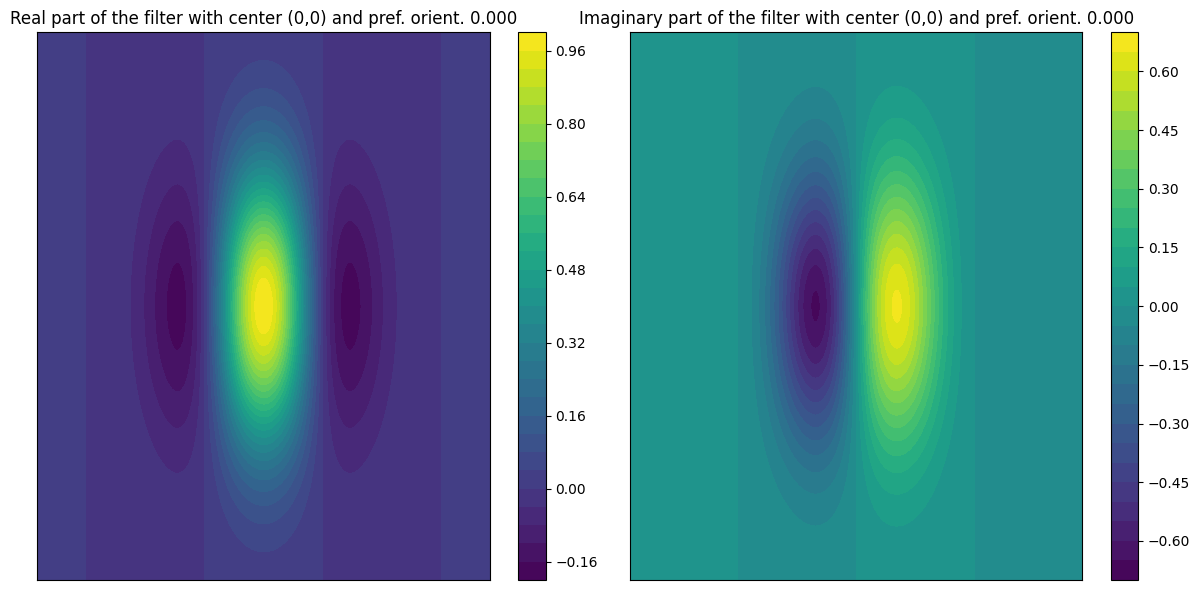

In [12]:
plot_gabor(0,0,0,False)

Let's now see the filter centered at (1,1) and rotated $\pi/4$

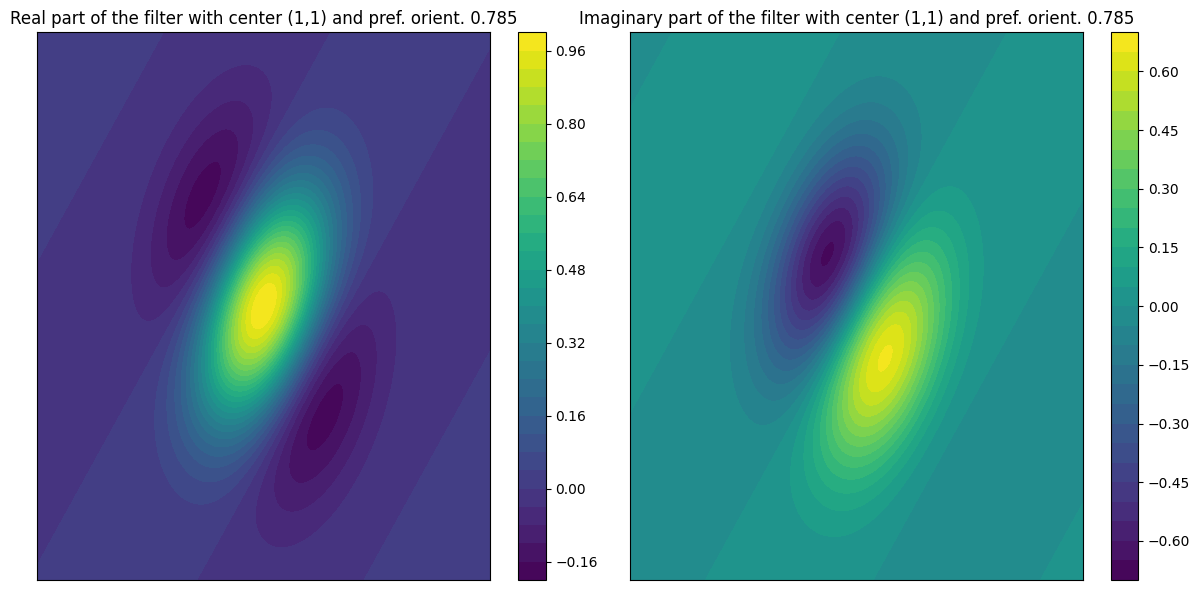

In [13]:
plot_gabor(1,1,np.pi/4)

## **Computational Model**

The next cell contains the model that allows obtaining the preferred orientations for each pixel of the image. Also included is the implementation of a Gabor filter by adjusting the centre $(x_0,y_0)$ and the orientation $\theta$.

In [14]:
class GCell:
    def __init__(self):
        self.recprof = lambda posiciones : np.exp(-((posiciones[:,:,0])**2 + (posiciones[:,:,1])**2)) * np.exp(2j*(posiciones[:,:,1]))

def AccionInv(posiciones,x,y,phi):
    #devuelve el punto con la rotacion inversa y desplazado -
    return np.matmul((posiciones - np.array([x,y])), np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]]))

def O(x,y,phi,imagen,gcell,posiciones):
    return np.sum(imagen * (gcell.recprof(posiciones)))

def searchPhiP(x,y,imagen,gcell):
    posiciones = np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2))

    espacioBusqueda = np.linspace(0,np.pi,60) #las fibras son S1 pero modulo pi

    return (espacioBusqueda[np.argmax(np.fromiter([np.abs(O(x,y,phi,imagen,gcell,AccionInv(posiciones,x,y,phi))) for phi in espacioBusqueda],dtype=np.float16))],x,y)

def allPhiP(imagen,gcell,startFromSomewhere=False):
    #startFromSomewhere: True retomo cálculo desde el json resultados/preferredOrientation_it, False desde cero
    arr = np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2)).reshape(-1, *np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2)).shape[2:])
    if not startFromSomewhere:
        prefdOr = {(x,y):None for x,y in arr}
    else:
        #retomamos el cálculo desde otro punto
        with open('resultados/preferredOrientation_it.json') as file:
            aux = json.load(file)
        mydict2 = {eval(k):v for k,v in aux.items()}
        prefdOr = mydict2 #este diccionario contiene Nones, voy a eliminar de arr aquellos cálculos que ya he hecho
        arr = np.array([t for t in arr if prefdOr[(t[0],t[1])] == None])

    total = arr.shape[0]
    update = 0
    division5porciento = int(total * 0.05) #saco paquetes de 5% del total

    print("Saving data in resultados/preferredOrientation_it.json")
    with tqdm(total=total) as progressB:
        with ThreadPoolExecutor() as executor:
            resultados = [executor.submit(lambda args : searchPhiP(imagen=imagen, gcell=gcell,**{'x':args[0], 'y':args[1]}), tup) for tup in arr]
            for future in as_completed(resultados):
                res, x, y = future.result()
                prefdOr[(x,y)] = res

                progressB.update(1)

                #voy a actualizar el guardado del cálculo cada 5% del total
                if progressB.n == total or (division5porciento != 0 and progressB.n%division5porciento == 0):
                    update+=1
                    #guardo en resultados/nombre_json
                    with open(f'resultados/preferredOrientation_it.json', 'w') as file:
                        json.dump({str(k): v for k, v in prefdOr.items()}, file, indent=4)
                    if progressB.n != total: print(f"Data update nº{update}")
                    else: print(f"Final update")

    return prefdOr

def scatterDict(datos,image,plotProyection=False):
    x = np.array([coord[0] for coord in datos.keys()])
    y = np.array([coord[1] for coord in datos.keys()])
    z = np.array(list(datos.values()))

    mycmap = 'viridis'

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(1, 2, 1)
    scatter1 = ax1.scatter(y, -x, c=z, cmap=mycmap) #invierto, si no sale al reves
    ax1.set_aspect('equal')
    ax1.set_xlabel('Eje X')
    ax1.set_ylabel('Eje Y')
    ax1.set_title('Preferred orientation for each point of the image')
    fig.colorbar(scatter1, ax=ax1, label='Preferred orientation [0,pi]',fraction=0.046, pad=0.04)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    if plotProyection:
        z_ = np.zeros(np.array(list(datos.values())).shape) #sirve para visualizar la proyección de los puntos
        scatter2 = ax2.scatter(x, y, z_, c=z, cmap=mycmap)  # El color de los puntos se basa en los valores de z
    else:
        scatter2 = ax2.scatter(x, y, z, c=z, cmap=mycmap)  # El color de los puntos se basa en los valores de z
    ax2.set_xlabel('Eje X')
    ax2.set_ylabel('Eje Y')
    ax2.set_zlabel('PhiP')
    ax2.set_title('Preferred orientation for each point of the image')
    fig.colorbar(scatter2, ax=ax2, label='Height = PhiP',fraction=0.046, pad=0.04)
    plt.tight_layout()


    plt.show()

    if not plotProyection:
        fig2 = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',marker=dict(size=1,color=z, colorscale='Viridis'))])
        fig2.update_layout(scene=dict(
                            xaxis_title='X Label',
                            yaxis_title='Y Label',
                            zaxis_title='Preferred height'))

        fig2.show()

class V1:
    def __init__(self, ruta_imagen, reducirPixeles=1, gaussianBlurr=False, gaussianKernel = 3):
        image = Image.open(ruta_imagen)
        pixel_size = reducirPixeles #reduzco complejidad
        ancho, alto = image.size
        nuevo_ancho = ancho // pixel_size
        nuevo_alto = alto // pixel_size
        imagen_pixelada = image.resize((nuevo_ancho, nuevo_alto), Image.NEAREST)
        image = imagen_pixelada.convert('L')
        imagen = np.array(image)
        if gaussianBlurr:
            gaussian_kernel = gaussianKernel
            imagen = cv2.GaussianBlur(imagen.copy(), (gaussian_kernel,gaussian_kernel), 0) #convoluciono por una gaussiana
        self.ruta_imagen = ruta_imagen
        self.imagen = imagen
        self.prefdOr = None

    def loadCalcs(self):
      with open("./safeCalcs/"+self.ruta_imagen.split(".")[0].split("/")[1]+".json") as file:
        aux = json.load(file)
      self.prefdOr = {eval(k):v for k,v in aux.items()}
      print("Calculations loaded for the image:  {}".format(self.ruta_imagen))

    def process(self, savedCalcs=False, loadCalcs=False):
        # si ya hay cálculos guardados en el directorio, retomar por donde se acabó con savedCalcs=True
        if loadCalcs :
          self.loadCalcs()
        else:
          ganglionarCell = GCell()
          self.prefdOr =  allPhiP(self.imagen, ganglionarCell, savedCalcs)

    def saveCalcs(self, rutaSave=None):
        if self.prefdOr == None :
          print("No data saved on the dictionary")
        elif rutaSave==None or (rutaSave in ['',' ']):
          print("Please introduce a name for the json to save it.")
        else:
          if os.path.exists("./resultados"):
            with open("./resultados"+rutaSave+".json", 'w') as file:
              json.dump({str(k): v for k, v in self.prefdOr.items()}, file, indent=4)
          else:
            os.makedirs("./resultados")
            with open("./resultados"+rutaSave+".json", 'w') as file:
              json.dump({str(k): v for k, v in self.prefdOr.items()}, file, indent=4)

    def show(self, flatten=False):
        scatterDict(self.prefdOr, self.imagen, flatten)

    def showFibration(self, addLines=False, addPoints=True, addInitial=True, addGaussianBlurr=False):
         #Hago la convolución con una gaussiana
        gaussifyed_image = cv2.GaussianBlur(self.imagen.copy(), (3,3), 2)

        # obtengo los puntos de la curva (bordes), en forma de indexado de puntos pixeles (x,y)
        if addGaussianBlurr :
            bordes = cv2.Canny(gaussifyed_image.copy(), 0, 10)
        else:
            bordes = cv2.Canny(self.imagen.copy(), 0, 10)

        #extraemos contornos (nos devuelve un orden apropiado para hacer el plot go)
        (contornos, _) = cv2.findContours(bordes.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #conts = cv2.drawContours(self.imagen.copy(),contornos,-1,(0,0,255), 2)

        fig = go.Figure(layout=dict(width=1000, height=1000))

        if addLines:
            for contorno in contornos:
                #cuando hacemos el findcontours puede haber varias componentes conexas
                contorno = contorno.reshape((contorno.shape[0],2))
                xe = contorno[:,1] #findcontours invierte las componentes
                ye = contorno[:,0]
                z = np.array([self.prefdOr[(i[1],i[0])] for i in contorno]) #invierte las componentes
                fig.add_trace(go.Scatter3d(x=xe, y=ye, z=z, mode='lines+markers', marker=dict(size=1,color=z,colorscale='Viridis'), line=dict(color=z,colorscale='Viridis', width=2)))


        #creo una matriz con todos los índices apuntando a pixeles de la self.imagen de los bordes
        indices_bordes = np.argwhere(np.ones_like(bordes)).reshape((*np.ones_like(bordes).shape,2))

        #tengo que hacer reshape a lo anterior para que sea una de tamaño 100,2
        indices_bordes = indices_bordes.reshape(-1, *np.argwhere(np.ones_like(self.imagen)).reshape((*np.ones_like(self.imagen).shape,2)).shape[2:])

        # ya tengo los índices de los puntos del borde de la imagen, ahora busco en mi diccionario self.prefdOr, y los subo al fibrado (creando otro diccionario)
        dic_bordes_fibrado = {(k[0],k[1]): self.prefdOr[(k[0],k[1])] if (bordes[(k[0],k[1])] == 255) else 0 for k in indices_bordes}

        #saco los puntos(indices) que pertenecen a un borde
        puntos_bordes_altura = {k:v for k,v in dic_bordes_fibrado.items() if dic_bordes_fibrado[k] != 0} #me quedo con los items quetengan altura
        puntos_cv = np.array([i for i in dic_bordes_fibrado.keys() if bordes[i[0],i[1]]!=0]) #puntos reales del borde 2D


        #saco los puntos 2D y la altura z
        puntos_bordes_2D = np.array(list(puntos_bordes_altura.keys()))
        z = np.array(list(puntos_bordes_altura.values()))

        #separo los x e y de puntos_bordes_2D
        x,y = puntos_bordes_2D[:,0], puntos_bordes_2D[:,1]

        if addPoints:
            fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2,color=z,colorscale='Viridis'), name='Original data'))

        if addInitial:
            fig.add_trace(go.Scatter3d(x=puntos_cv[:,0].ravel(), y=puntos_cv[:,1].ravel(), z=np.zeros(puntos_cv[:,1].ravel().size), mode='markers', marker=dict(size=1,color='red'), name='Original'))

        fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Preferred height'))
        fig.show()

<br><br><br>
Once the code is defined, the following form allows you to adjust the parameters to process the image. You need to execute the form cell once.

<br><br>

<p style="font-size: 2em;">Parameter</p> | <p style="font-size: 2em;">Description</p>
--- | ---
<p style="font-size: 2em;">**`imageToLoad`**</p>    | <p style="font-size: 2em;">The image to load for calculations. It can be selected from a list of options. <br> <br> <p style="font-size: 2em; color: red;">You can upload your own image to Colab to process it with the model; it is necessary to save the image in ./img (on the left sidebar in the folder icon) and set <br> this parameter appropriately with the image name, by selecting it in the dropdown.</p> </p>    
<p style="font-size: 2em;">**`pixelReduction`** </p>   | <p style="font-size: 2em;">The pixel reduction to apply to the loaded image. It is controlled using a slider. <br><br> Reduces the complexity of calculations by pixelating the image.  </p>    
<p style="font-size: 2em;">**`addGaussianBlurr`** </p>   | <p style="font-size: 2em;">A boolean flag that determines whether to apply Gaussian blur to the image.     </p>          
<p style="font-size: 2em;">**`gaussianKernel`**  </p>  | <p style="font-size: 2em;">The size of the Gaussian kernel to apply if `addGaussianBlurr` is true. </p>
<p style="font-size: 2em;">**`loadCalcs`**  </p>  | <p style="font-size: 2em;">A boolean flag that determines whether to load previously saved calculations. <br><br> Setting it to `True` will load pre-saved calculations from `./safeCalcs` for the image chosen by `imageToLoad`.<br><br> All pre-saved calculations were obtained using images without Gaussian blur and without reduction <br>(`addGaussianBlurr=False` and `pixelReduction=1`) </p>
<p style="font-size: 2em;">**`resumeCalcs`**  </p>  | <p style="font-size: 2em;">A boolean flag that determines whether to resume saved calculations if available. <br><br> Useful when calculations on an image from scratch (with `loadCalcs=False`) are interrupted <br> and you want to resume calculations from the point where the algorithm stopped. </p>

<br><br><br>


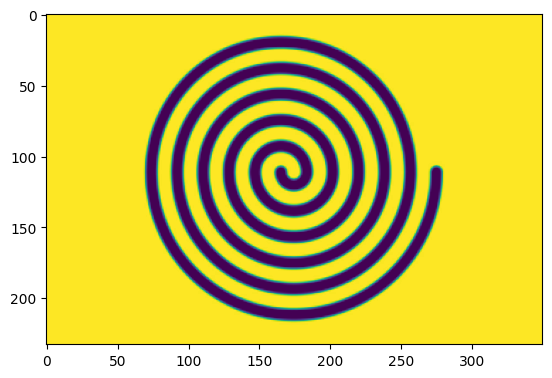

In [16]:
# @title Model parameters { run: "auto", form-width: "50%", display-mode: "form" }
!ls ./img > ./img/aux
imagenes = []
with open('./img/aux') as file:
    for image in file.readlines()[1:]:
        #descarto el nombre del archivo y limpio el nombre de /n
        imagenes.append(image.replace('\n',''))
    file.close()
#print(imagenes) #descomentar para detectar nuevas imagenes en img para el formulario
!rm -f ./img/aux

#tengo que copiar manualmente el contenido de imagenes en el param abajo
imageToLoad = "espiral.png" # @param ['circle.png', 'cohete.png', 'einstmary.jpg', 'espiral.png', 'kanizsa.jpg', 'linea.png', 'perro.jpg', 'semicircle.png', 'semiestere.jpg', 'toro.png']
pixelReduction = 1 # @param {type:"slider", min:1, max:30, step:1}
addGaussianBlurr = False # @param {type:"boolean"}
gaussianKernel = 3 # @param {type:"slider", min:3, max:25, step:2}
loadCalcs = True # @param {type:"boolean"}
resumeCalcs = False # @param {type:"boolean"}

imagenAux = Image.open(f'img/{imageToLoad}')
pixel_size = pixelReduction #reduzco complejidad
ancho, alto = imagenAux.size
nuevo_ancho = ancho // pixel_size
nuevo_alto = alto // pixel_size
imagenAux = imagenAux.resize((nuevo_ancho, nuevo_alto), Image.NEAREST)
imagenAux = np.array(imagenAux)
if addGaussianBlurr:
    imagenAux = cv2.GaussianBlur(imagenAux.copy(), (gaussianKernel,gaussianKernel), 0)

_ = plt.imshow(imagenAux)

Once the previous parameters are defined, we create an instance of the V1 class, which will be responsible for processing the image.

We run the model, which will use the parameters from the previous form.

In [17]:
myV1 = V1(f'img/{imageToLoad}',reducirPixeles = pixelReduction, gaussianBlurr = addGaussianBlurr, gaussianKernel = gaussianKernel)
myV1.process(loadCalcs=loadCalcs, savedCalcs=resumeCalcs)

Calculations loaded for the image:  img/espiral.png


We can visualize the preferred orientations calculated for each point of the image. We adjust a parameter.

<br> <p style="font-size: 2em;">Parameter</p> | <p style="font-size: 2em;">Description</p>
--- | ---
<p style="font-size: 2em;">**`flattenFibration`**</p> | <p style="font-size: 2em;">If `True`, the bundle is displayed flattened on the plane $z=0$</p> <br>


It is necessary to run the form cell once.

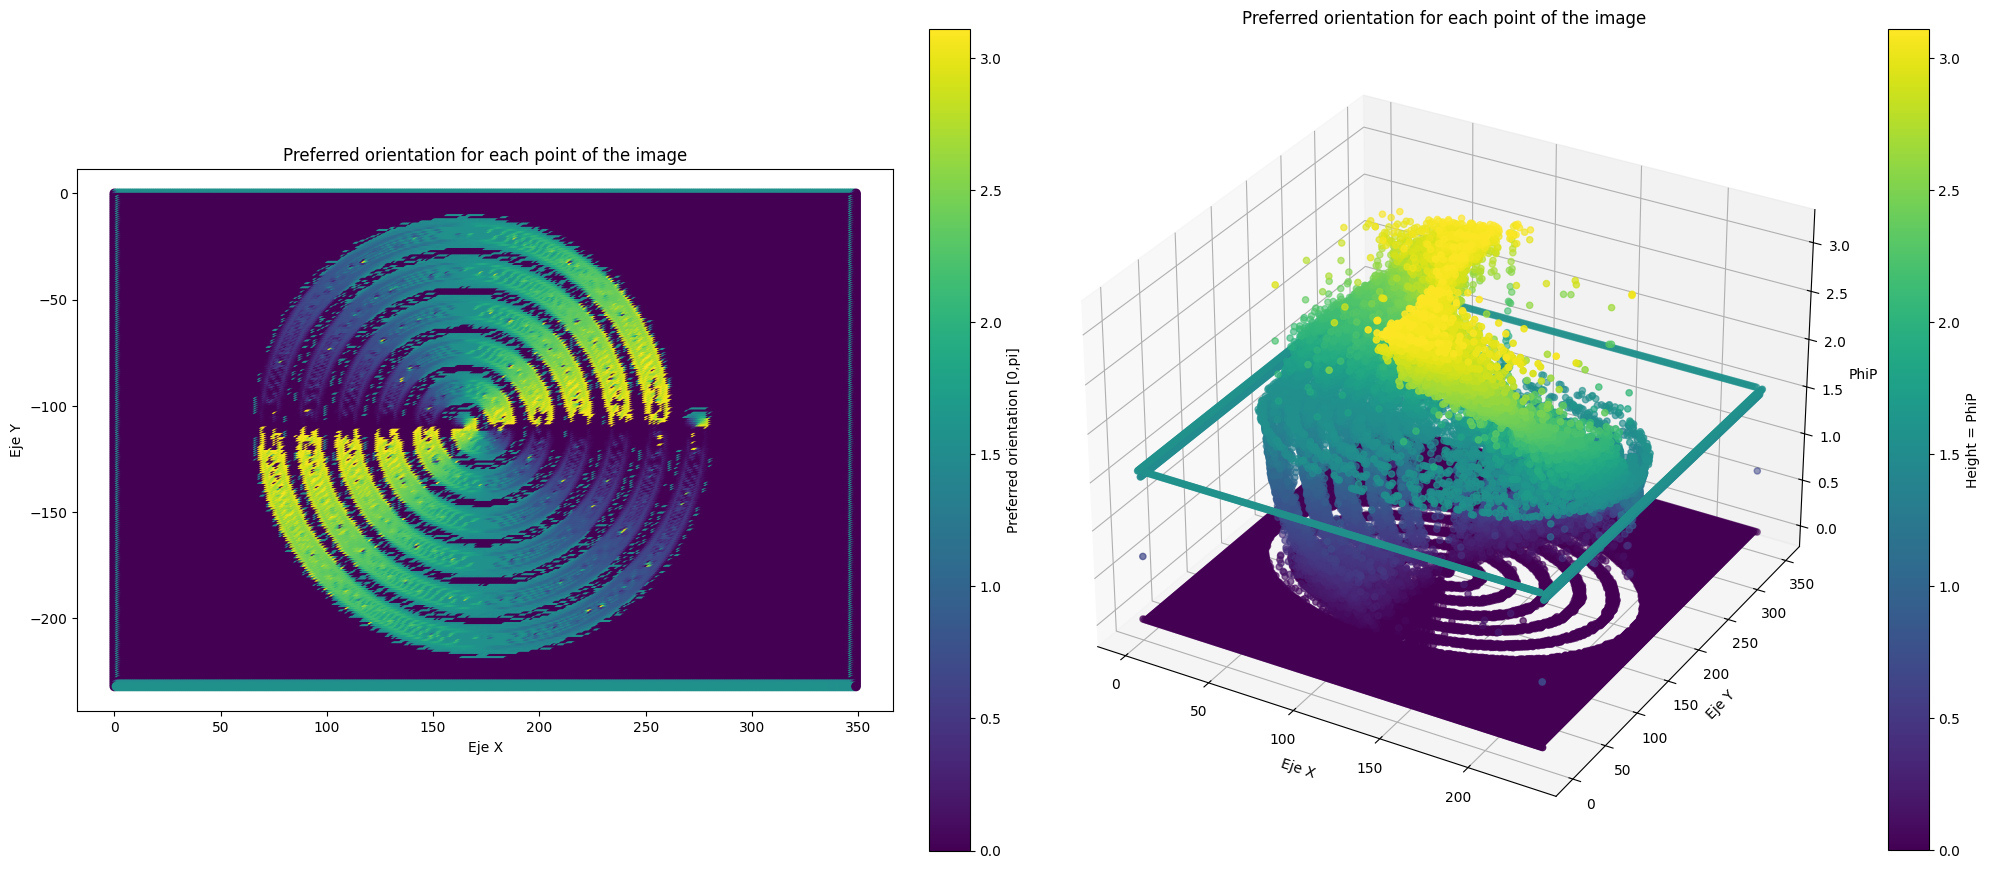

In [19]:
# @title First visualization of the preferred orientations { run: "auto" }
flattenFibration = False # @param {type:"boolean"}

myV1.show(flatten = flattenFibration) #add flatten si se quiere

## **Visualization of the bundle**

Let's take a clearer look at the bundle.

<br> <p style="font-size: 2em;">Parameter</p> | <p style="font-size: 2em;">Description</p>
 --- | ---
 <p style="font-size: 2em;">**`addLines`**</p> | <p style="font-size: 2em;">A boolean indicator that determines whether to add the Legendrian elevations of the contour to the bundle.</p>
 <p style="font-size: 2em;">**`addPoints`**</p> | <p style="font-size: 2em;">A boolean indicator that determines whether to add the points that indicate the preferred orientations in the bundle.</p>
 <p style="font-size: 2em;">**`addInitial`**</p> | <p style="font-size: 2em;">A boolean indicator that determines whether to add the original contours on the plane $z=0$.</p>
 <p style="font-size: 2em;">**`addGaussianBlurr`**</p> | <p style="font-size: 2em;">A boolean indicator that determines whether to apply Gaussian blur to the image contours.</p>
<br><br>

In [ ]:
# @title Parameters for the visualization of the bundle { run: "auto", vertical-output: true }
addLines = True # @param {type:"boolean"}
addPoints = True # @param {type:"boolean"}
addInitial = True # @param {type:"boolean"}
addGaussianBlurr = True # @param {type:"boolean"}
#addLines=False, addPoints=True, addInitial=True, addGaussianBlurr=False

myV1.showFibration(addLines, addPoints, addInitial, addGaussianBlurr)